In [1]:
# Elliptical Envelope

In [2]:
import pandas as pd
import time
from sklearn.covariance import EllipticEnvelope
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  pairwise 
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [3]:
start = time.time()
df = pd.read_csv('1mill_sample_anomaly.csv')
end = time.time()
print(end - start)

2.3543481826782227


In [4]:
#df2 = df.sample(n=1000000)
dfNum = df[['Duration', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes']]

In [5]:
# Looking at the distribution of the columns to see whether individually the data are normally distributed.
# This algorithm assumes that the data are Gaussian

In [6]:
start = time.time()
ee = EllipticEnvelope(contamination=0.01)
ee.fit(dfNum)
labels = ee.predict(dfNum)
end = time.time()
print("Time: ", end - start)

Time:  239.64980483055115


In [9]:
# Intra cluster distance 
start = time.time()
dfNum['Outlier'] = labels
benign = dfNum[dfNum['Outlier'] == 1]
anomalies = dfNum[dfNum['Outlier'] == -1]
benign_centroid = benign.mean().values
full_centroid = dfNum.mean().values

full_spread = 0
for index, row in dfNum.iterrows():
    d = np.sum(np.square(full_centroid - row.values))
    full_spread = full_spread + d
    
benign_spread = 0
for index, row in benign.iterrows():
    d = np.sum(np.square(benign_centroid - row.values))
    benign_spread = benign_spread + d
    
ratio = (full_spread / dfNum.shape[0]) / (benign_spread / benign.shape[0])
print(ratio)
end = time.time()
print("Time: ", end - start)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


101990.32387908472
Time:  174.22297048568726


In [10]:
# Adding the labels as a column to the ensembling df
ensemble = pd.read_csv('1mill_anomaly_ensemble_df.csv')

In [11]:
ensemble['EE_0.01_Lables'] = labels
ensemble.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes,LOF_0.01_Labels,EE_0.01_Lables
0,0,2615150,7081118,7120234,175674,0,Comp965575,Comp584379,6,Port00067,443,11,7,1577,3911,1,1
1,1,3424367,80091742,80597928,206274,815,Comp393882,Comp591308,6,Port11291,80,6,6,474,2205,1,1
2,2,871645,33512751,33683446,187662,1,Comp279702,Comp362299,17,Port77194,161,7,7,640,1365,1,1
3,3,4456841,79100858,79602043,205992,1,Comp030334,Comp348022,6,Port51000,Port21834,4,3,216,160,1,1
4,4,3515765,15023239,15078975,179497,1,Comp581624,ActiveDirectory,6,Port67196,389,9,7,6871,587,1,1


In [13]:
ensemble.to_csv('1mill_anomaly_ensemble_df.csv')

In [7]:
# Chi Squared Test to see whether anomalies and normal traffic have different DstPort Distribution

In [8]:
# Removing 'Port' from the port names and grouping ports into 3 categories
df['DstPort'] = df['DstPort'].str.replace('Port', '')
df['DstPort'] = df['DstPort'].astype(int)
df['DstPortCategory'] = np.where(df['DstPort']<=1023, 'System Ports', 'User Ports')
df['DstPortCategory'][df['DstPort']>=49152] = 'Dynamic and/or Private Ports'

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [9]:
# Chi-Squared Test to Test Whether Anomalous and Benign Five-Tuples have significantly 
# differnt port dist
df['Outlier'] = labels
cont_tab = pd.crosstab(index=df['Outlier'], columns=df['DstPortCategory'])
print(cont_tab)
from scipy import stats
stats.chi2_contingency(cont_tab)

DstPortCategory  Dynamic and/or Private Ports  System Ports  User Ports
Outlier                                                                
-1                                        927          8295         778
 1                                     198041        510179      281780


(3956.7419963878056, 0.0, 2, array([[  1989.68,   5184.74,   2825.58],
        [196978.32, 513289.26, 279732.42]]))

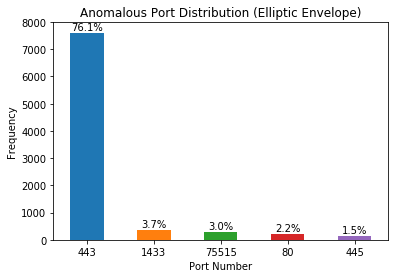

In [11]:
# Creating a plot of the ports for anomalous five tuples
anomalies2 = df[df['Outlier']==-1]
freq_series = pd.Series(anomalies2['DstPort'].value_counts().head(5).values)
x_labels = pd.Series(anomalies2['DstPort'].value_counts().head(5).index)
ax = freq_series.plot(kind='bar')
ax.set_title('Anomalous Port Distribution (Elliptic Envelope)')
ax.set_xlabel('Port Number')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['DstPort'].value_counts().head(6)*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('EE_anomalous_portDist_0.01contam.png')

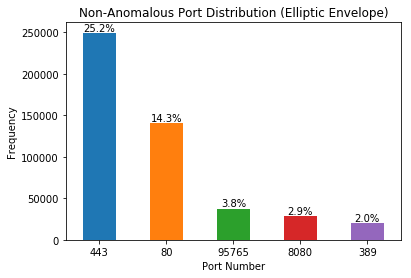

In [12]:
# Creating a plot of the ports for non-anomalous five tuples
anomalies2 = df[df['Outlier']==1]
freq_series = pd.Series(anomalies2['DstPort'].value_counts().head(5).values)
x_labels = pd.Series(anomalies2['DstPort'].value_counts().head(5).index)
ax = freq_series.plot(kind='bar')
ax.set_title('Non-Anomalous Port Distribution (Elliptic Envelope)')
ax.set_xlabel('Port Number')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['DstPort'].value_counts().head(6)*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('EE_nonanomalous_portDist_0.01contam.png')

In [14]:
# Chi-Squared Test to Test Whether Anomalous and Benign Five-Tuples have significantly 
# differnt protocol dist
cont_tab2 = pd.crosstab(index=df['Outlier'], columns=df['Protocol'])
print(cont_tab2)
from scipy import stats
stats.chi2_contingency(cont_tab2)

Protocol      6      17
Outlier                
-1          9804    196
 1        946774  43226


(137.42509222819436,
 9.734703494645553e-32,
 1,
 array([[9.5657800e+03, 4.3422000e+02],
        [9.4701222e+05, 4.2987780e+04]]))

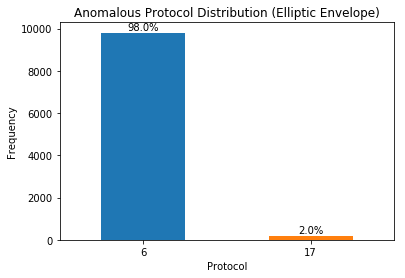

In [15]:
# Creating a plot of the protocols for anomalous five tuples
anomalies2 = df[df['Outlier']==-1]
freq_series = pd.Series(anomalies2['Protocol'].value_counts().values)
x_labels = pd.Series(anomalies2['Protocol'].value_counts().index)
ax = freq_series.plot(kind='bar')
ax.set_title('Anomalous Protocol Distribution (Elliptic Envelope)')
ax.set_xlabel('Protocol')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(anomalies2['Protocol'].value_counts()*100/len(anomalies2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('EE_anomalous_protocolDist_0.01contam.png')

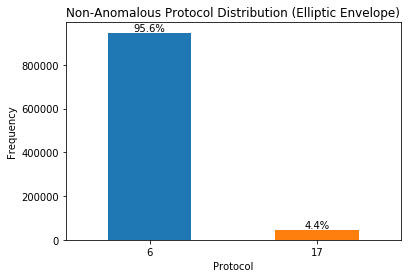

In [16]:
# Creating a plot of the protocols for non-anomalous five tuples
benign2 = df[df['Outlier']==1]
freq_series = pd.Series(benign2['Protocol'].value_counts().values)
x_labels = pd.Series(benign2['Protocol'].value_counts().index)
ax = freq_series.plot(kind='bar')
ax.set_title('Non-Anomalous Protocol Distribution (Elliptic Envelope)')
ax.set_xlabel('Protocol')
ax.set_ylabel('Frequency')
ax.set_xticklabels(x_labels)
plt.xticks(rotation=360)
rects = ax.patches

# Make some labels.
#labels = ["label%d" % i for i in range(len(rects))]
percs = list(benign2['Protocol'].value_counts()*100/len(benign2))
percs = [round(perc, 1) for perc in percs]
labels = [str(perc)+'%' for perc in percs]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.savefig('EE_benign_protocolDist_0.01contam.png')

In [10]:
# Plotting PCA to Visualize Anomalies
# Scaling for PCA
start = time.time()
pre = preprocessing.scale(dfNum[["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]])
pre = pd.DataFrame.from_records(pre, columns = ["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"])
print(pre.head())
end = time.time()
print(end - start)

   Duration  SrcPackets  DstPackets  SrcBytes  DstBytes
0 -0.057348   -0.007769   -0.007146 -0.007357 -0.006343
1 -0.059889   -0.009194   -0.008372 -0.009493 -0.006900
2 -0.059740   -0.008440   -0.008022 -0.009135 -0.006695
3 -0.059740   -0.009194   -0.008372 -0.009493 -0.006900
4 -0.059889   -0.008859   -0.007963 -0.009451 -0.006278
1.6984870433807373


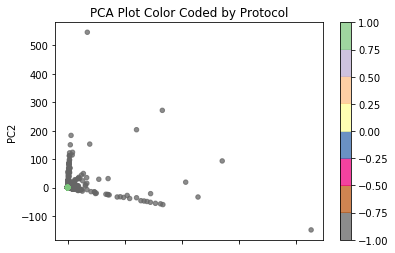

39.73135447502136


In [11]:
# PCA plot of protocol and numerical values-- color coded by Protocol
start = time.time()
pcaDF = pre[["Duration", "SrcPackets", "DstPackets", "SrcBytes", "DstBytes"]]
pca = PCA(n_components=2).fit_transform(pcaDF)
pcdf = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])
pcdf.plot(x="PC1", y="PC2", kind='scatter', title='PCA Plot Color Coded by Protocol', 
          c=dfNum['Outlier'] , legend=True, colormap = 'Accent_r', alpha = 0.75)
plt.savefig('1mill_PCA_EE.png')
plt.show()
end = time.time()
print(end - start)

1    120312
Name: Outlier, dtype: int64

In [13]:
# The data are dense around the origin, and it seems that the ellipse fits around the dense part of the data and 
# calls all the data with large values anomalies. This could be a good method for detecting anomalies, since SIEDS paper
# showed that abnormal activity has higher values for packets and bytes.

In [38]:
# Finding distance of every point to centroid
start = time.time()
centroid_all = dfNum.mean().values.tolist()
dfNum['Distance0'] = dfNum['Duration'] - 353.4736
#print(dfNum['Distance0'])
end = time.time()
print(end - start)

0.04362201690673828


/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [39]:
# Show that anomalies and normal are statistically different?
anomalous = dfNum[dfNum['Outlier']==-1]